# Presentation

This notebook is modified version (with added comments) of presentation given by Bart Grasza on 2017.07.15

# Goals of the notebook

This notebook has multiple purposes:

- what is and how to use Keras ```Lambda()``` layer
- how to use it to implement e.g. math operations from ML scientific papers
- how Keras is using underlying backends
- what is the difference between Keras model and Theano/TensorFlow graph


The bigger idea behind all of this is: 

TensorFlow/Theano is powerful but much more complex than Keras. You can easily end up writing 10 times more code. You should stick to Keras, but what if at some point you feel limited by what can be achieved using Keras? What if instead of switching to pure TensorFlow/Theano, you could use them from within Keras? I will try to explain this concept with theory and code examples. 

----------

Note: This notebook focuses on TensorFlow being used as Keras backend.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

# Keras model graph
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot
# ... and drawing helper
def draw_model_graph(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))    

Using TensorFlow backend.


## Python lambda - anonymous function

(you can skip this section if you know python'a ```lambda``` function)

Before we dive into Keras Lambda layer, you should get familiar with python lambda function. You can read more about it e.g. here: http://www.secnetix.de/olli/Python/lambda_functions.hawk

Below I show how lambda works together with python map() method, which is very similar to how it's being used in Keras Lambda layer

In [2]:
a = [1, 2, 3, 4]
map(lambda x: x*2, a)

[2, 4, 6, 8]

If argument passed is list of lists, you can refer to it's elements in standard fashion:

In [67]:
a = [[1, 1], 
     [2, 2], 
     [3, 3], 
     [4, 4]]
map(lambda x: x[0]*x[1], a)

[1, 4, 9, 16]

Lambda function can be "un-anomized"

In [105]:
a = [1, 2, 3, 4]

# Syntax:
# map(lambda x: x*2, a)
# is similar to:

def times_two(x):
    return x*2
map(times_two, a)

[2, 4, 6, 8]

## Keras Lambda layer - custom operations on model

Below is simple keras model (fed with randomly generated data) to show how you can perform custom operations on data from previous layer. Here we're taking data from ```dense_layer``` and multiply it by 2

In [15]:
X1 = np.random.rand(1000, 50)
X2 = np.random.rand(1000, 50)
Y = np.random.rand(1000,)

In [16]:
input = Input(shape=(50,))
dense_layer = Dense(30)(input)
##################
merge_layer = Lambda(lambda x: x*2)(dense_layer)
##################
output = Dense(1)(merge_layer)

model = Model(inputs=input, outputs=output)
model.compile(loss='mse', optimizer='adam')
model.fit(x=X1, y=Y)

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 1.0388     


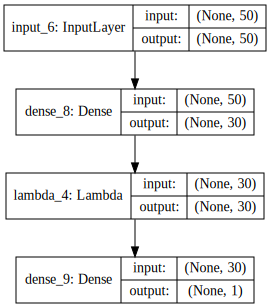

In [17]:
draw_model_graph(model)

## Model using custom operation (cosine similarity) on "output"

All the examples in Keras online documentation and in http://fast.ai course show how to build a model with output being fully connected ( ```Dense()``` ) layer.

Here I show the example of model which, given 2 vectors on the input, expects on the output cosine similarity score between these vectors. Cosine similarity can have values from ```< -1, 1 >```, where close to ```1``` represents 2 vectors being similar/almost similar. Close to ```-1``` represents 2 vectors being very different.

The exact equation is:

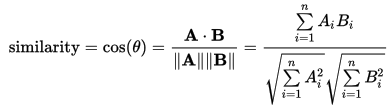

In [2]:
Image(filename='images/cos_distance.png')

I skip the details of Keras implementation of above equation, instead focus on the ```Lambda``` layer.

Notes:
- our ```output``` layer isn't ```Dense()``` but ```Lambda()```.
- ```print()``` statement shows example ```Tensor``` from Lambda calculation being type ```tensorflow.python.framework.ops.Tensor```
- Keras documentation for Lamda layer says that for TensorFlow you don't need to specify ```output_shape``` but it's not always the truth. In the case of model below where it accepts 2 inputs, it couldn't figure out correct output shape.

In [18]:
input_1 = Input(shape=(50,))
d1 = Dense(30)(input_1)

input_2 = Input(shape=(50,))
d2 = Dense(30)(input_2)

def merge_layer(layer_input):
    x1_l2_norm = K.l2_normalize(layer_input[0], axis=1)
    print(x1_l2_norm)
    print(type(x1_l2_norm))
    x2_l2_norm = K.l2_normalize(layer_input[1], axis=1)
    mat_mul = K.dot(x1_l2_norm, 
                    K.transpose(x2_l2_norm))
    return K.sum(mat_mul, axis=1)
    
output = Lambda(merge_layer, output_shape=(1,))([d1, d2]) 

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.fit(x=[X1, X2], y=Y)

Tensor("lambda_5/l2_normalize:0", shape=(?, 30), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 6.7006      


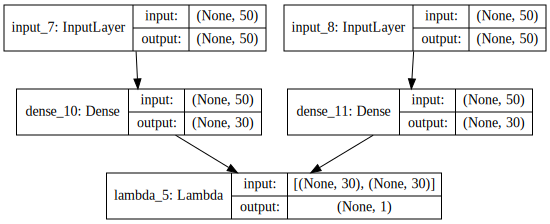

In [19]:
draw_model_graph(model)

Let's have a look at backend implementation.

If you git clone Keras repository (https://github.com/fchollet/keras), open file: ```keras/backend/tensorflow_backend.py```

and look for ```l2_normalize(x, axis)``` method, you will see this:

In [282]:
# copied from Keras, file: tensorflow_backend.py

def l2_normalize(x, axis):
    """Normalizes a tensor wrt the L2 norm alongside the specified axis.

    # Arguments
        x: Tensor or variable.
        axis: axis along which to perform normalization.

    # Returns
        A tensor.
    """
    if axis < 0:
        axis %= len(x.get_shape())
    return tf.nn.l2_normalize(x, dim=axis)

As you can see, the keras ```l2_normalize``` is very thin layer on top of tensorflow ```tf.nn.l2_normalize``` function.

----------

#### What would happen if we just replace all keras functions with tensorflow equivalents?

Below you can see exactly the same model as above but directly using TensorFlow methods

In [21]:
input_1 = Input(shape=(50,))
d1 = Dense(30)(input_1)

input_2 = Input(shape=(50,))
d2 = Dense(30)(input_2)

def merge_layer(layer_input):
    x1_l2_norm = tf.nn.l2_normalize(layer_input[0], dim=1) # notice axis -> dim
    x2_l2_norm = tf.nn.l2_normalize(layer_input[1], dim=1)
    mat_mul = tf.matmul(x1_l2_norm, 
                    tf.transpose(x2_l2_norm))
    return tf.reduce_sum(mat_mul, axis=1)
    
output = Lambda(merge_layer, output_shape=(1,))([d1, d2])

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.fit(x=[X1, X2], y=Y)

Epoch 1/1
1000/1000 [==============================] - 0s - loss: 8.5423      


It still works!

#### What are benefits of doing that?

Tensorflow has very rich library of functions, some of them are not available in Keras, so this way you can still use all goodies from TensorFlow!

#### What are the drawbacks?

The moment you start directly using TensorFlow, your code stops working in Theano. It's not a big problem if you made a choice of always using single Keras backend.

## Example: how to use what we've learned so far to implement more complex NN

In this section we will slightly divert from main topic and show how you can implement part of the real scientific paper. 

Paper we're going to use is: http://www.mit.edu/~jonasm/info/MuellerThyagarajan_AAAI16.pdf

The goal is to train NN to measure similarity between 2 sentences. You can read paper for details how the sentences are being transformed into vectors, here we only focus on the last part where each sentence is already in vector format.

The idea is that the closer the value of compared sentences to 1 is, the sentences are more similar. The closer the value to 0 means that sentences are different.

In the PDF, If you scroll to the bottom of page 3, you can see following equation:

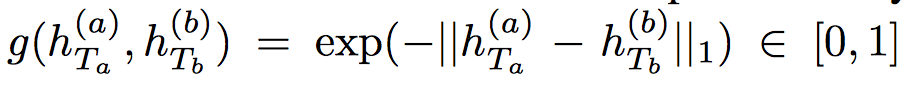

In [3]:
Image(filename='images/vec_sim.png', width=400)

Let's try to break down this equation.

First, notice that $h_{T_a}^{(a)}$ and $h_{T_b}^{(b)}$ represent sentences transformed into vectors representation.

The ```exp()``` is simply $e^x$ and if you plot it, it looks like this:

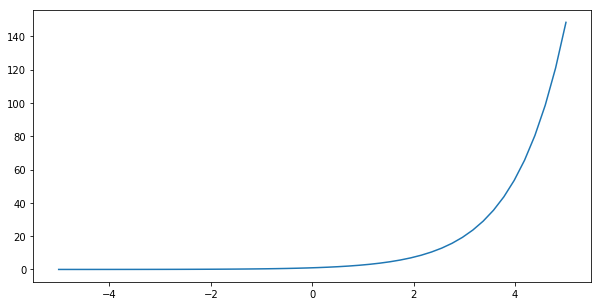

In [41]:
x = np.linspace(-5, 5, 50)
y = np.exp(x)
plt.figure(figsize=(10, 5))
plt.plot(x, y)

If we zoom in $x$ axis to $<-1, 1>$, we can see that for $x$ == 0 the value is 1

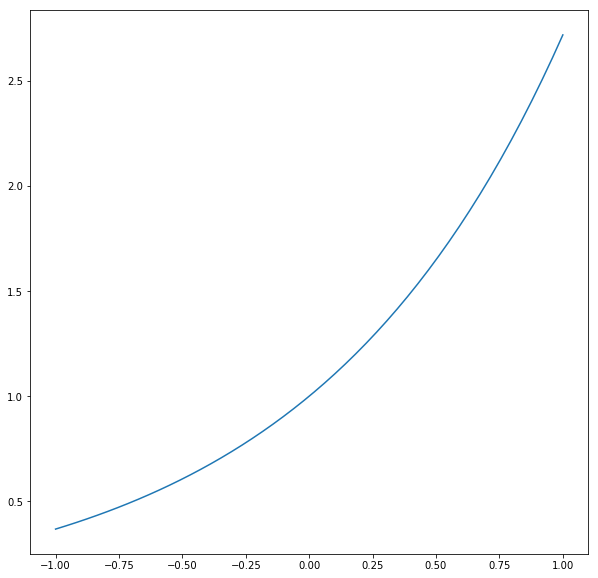

In [36]:
x = np.linspace(-1, 1, 50)
y = np.exp(x)
plt.figure(figsize=(10,10))
plt.plot(x, y)

Now we can flip it horizontaly by $f(x)$ axis by just adding minus sign to $x$: $e^{-x}$

The plot changes to:

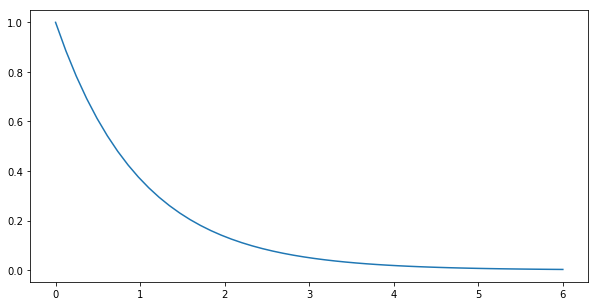

In [100]:
x = np.linspace(0, 6, 50)
y = np.exp(-x)
plt.figure(figsize=(10,5))
plt.plot(x, y)

The higher value of $x$, the closer $f(x)$ value is to 0!

------------

Now we just need to find a way how to combine 2 vectors so that:
- when they are similar, they will give $x$ close to 0 and 
- the more different they are, the value of $x$ should be higher.


To achieve that, authors used L1 distance (https://en.wikipedia.org/wiki/Taxicab_geometry ), which basically is a absolute (method ```tf.abs()``` ) difference between values in each dimention. It is represented by $\lVert \mathbf{p - q} \rVert_1$ in our original equation.

All above can be represented by code in ```merge_layer(layer_input)```:

In [24]:
input_1 = Input(shape=(50,))
d1 = Dense(30)(input_1)

input_2 = Input(shape=(50,))
d2 = Dense(30)(input_2)

def merge_layer(layer_input):
    v1 = layer_input[0]
    v2 = layer_input[1]
    
    # L1 distance operations
    sub_op = tf.subtract(v1, v2)
    print("tensor: %s" % sub_op)
    print("sub_op.shape: %s" % sub_op.shape)
    abs_op = tf.abs(sub_op)
    print("abs_op.shape: %s" % abs_op.shape)
    sum_op = tf.reduce_sum(abs_op, axis=-1)
    print("sum_op.shape: %s" % sum_op.shape)
    
    # ... followed by exp(-x) part
    reverse_op = -sum_op
    out = tf.exp(reverse_op)
    
    return out
    
    # The same but in single line 
    # pred = tf.exp(-tf.reduce_sum(tf.abs(tf.subtract(v1, v2)), axis=-1))
    
output = Lambda(merge_layer, output_shape=(1,))([d1, d2])

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='mse', optimizer='adam')
m = model.fit(x=[X1, X2], y=Y)

tensor: Tensor("lambda_7/Sub:0", shape=(?, 30), dtype=float32)
sub_op.shape: (?, 30)
abs_op.shape: (?, 30)
sum_op.shape: (?,)
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.3327     


## Writing custom layer

When should you use Lambda and when you need to write custom layer?

Quote from: 
https://keras.io/layers/writing-your-own-keras-layers/ :

"For simple, stateless custom operations, you are probably better off using ```layers.core.Lambda``` layers. But for any custom operation that has trainable weights, you should implement your own layer."


### -----------------------

# Full list of Keras backend functions with types

List below represents all functions from Keras repository ```tensorflow_backend.py```

I'm showing them here so that you could quickly see how many useful methods it has, notice many similar methods implemented in Numpy.

## INTERNAL UTILS
```
get_uid(prefix='')
reset_uids()
clear_session()
manual_variable_initialization(value)
learning_phase()
set_learning_phase(value)
get_session()
set_session(session)
```

## VARIABLE MANIPULATION

```
_convert_string_dtype(dtype)
_to_tensor(x, dtype)
is_sparse(tensor)
to_dense(tensor)
variable(value, dtype=None, name=None)
_initialize_variables()
constant(value, dtype=None, shape=None, name=None)
is_keras_tensor(x)
placeholder(shape=None, ndim=None, dtype=None, sparse=False, name=None)
shape(x)
int_shape(x)
ndim(x)
dtype(x)
eval(x)
zeros(shape, dtype=None, name=None)
ones(shape, dtype=None, name=None)
eye(size, dtype=None, name=None)
zeros_like(x, dtype=None, name=None)
ones_like(x, dtype=None, name=None)
identity(x)
random_uniform_variable(shape, low, high, dtype=None, name=None, seed=None)
random_normal_variable(shape, mean, scale, dtype=None, name=None, seed=None)
count_params(x)
cast(x, dtype)
```

## UPDATES OPS
```
update(x, new_x)
update_add(x, increment)
update_sub(x, decrement)
moving_average_update(x, value, momentum)
```

## LINEAR ALGEBRA
```
dot(x, y)
batch_dot(x, y, axes=None)
transpose(x)
gather(reference, indices)
```

## ELEMENT-WISE OPERATIONS
```
_normalize_axis(axis, ndim)
max(x, axis=None, keepdims=False)
min(x, axis=None, keepdims=False)
sum(x, axis=None, keepdims=False)
prod(x, axis=None, keepdims=False)
cumsum(x, axis=0)
cumprod(x, axis=0)
var(x, axis=None, keepdims=False)
std(x, axis=None, keepdims=False)
mean(x, axis=None, keepdims=False)
any(x, axis=None, keepdims=False)
all(x, axis=None, keepdims=False)
argmax(x, axis=-1)
argmin(x, axis=-1)
square(x)
abs(x)
sqrt(x)
exp(x)
log(x)
logsumexp(x, axis=None, keepdims=False)
round(x)
sign(x)
pow(x, a)
clip(x, min_value, max_value)
equal(x, y)
not_equal(x, y)
greater(x, y)
greater_equal(x, y)
less(x, y)
less_equal(x, y)
maximum(x, y)
minimum(x, y)
sin(x)
cos(x)
normalize_batch_in_training(x, gamma, beta,
batch_normalization(x, mean, var, beta, gamma, epsilon=1e-3)
```

## SHAPE OPERATIONS

```
concatenate(tensors, axis=-1)
reshape(x, shape)
permute_dimensions(x, pattern)
resize_images(x, height_factor, width_factor, data_format)
resize_volumes(x, depth_factor, height_factor, width_factor, data_format)
repeat_elements(x, rep, axis)
repeat(x, n)
arange(start, stop=None, step=1, dtype='int32')
tile(x, n)
flatten(x)
batch_flatten(x)
expand_dims(x, axis=-1)
squeeze(x, axis)
temporal_padding(x, padding=(1, 1))
spatial_2d_padding(x, padding=((1, 1), (1, 1)), data_format=None)
spatial_3d_padding(x, padding=((1, 1), (1, 1), (1, 1)), data_format=None)
stack(x, axis=0)
one_hot(indices, num_classes)
reverse(x, axes)
```

## VALUE MANIPULATION
```
get_value(x)
batch_get_value(ops)
set_value(x, value)
batch_set_value(tuples)
get_variable_shape(x)
print_tensor(x, message='')
```

## GRAPH MANIPULATION
```
(class) class Function(object)
function(inputs, outputs, updates=None, **kwargs)
gradients(loss, variables)
stop_gradient(variables)
```

## CONTROL FLOW
```
rnn(step_function, inputs, initial_states,
_step(time, output_ta_t, *states)
_step(time, output_ta_t, *states)
switch(condition, then_expression, else_expression)
then_expression_fn()
else_expression_fn()
in_train_phase(x, alt, training=None)
in_test_phase(x, alt, training=None)
```

## NN OPERATIONS
```
relu(x, alpha=0., max_value=None)
elu(x, alpha=1.)
softmax(x)
softplus(x)
softsign(x)
categorical_crossentropy(output, target, from_logits=False)
sparse_categorical_crossentropy(output, target, from_logits=False)
binary_crossentropy(output, target, from_logits=False)
sigmoid(x)
hard_sigmoid(x)
tanh(x)
dropout(x, level, noise_shape=None, seed=None)
l2_normalize(x, axis)
in_top_k(predictions, targets, k)
```

## CONVOLUTIONS
```
_preprocess_deconv3d_output_shape(x, shape, data_format)
_preprocess_deconv_output_shape(x, shape, data_format)
_preprocess_conv2d_input(x, data_format)
_preprocess_conv3d_input(x, data_format)
_preprocess_conv2d_kernel(kernel, data_format)
_preprocess_conv3d_kernel(kernel, data_format)
_preprocess_padding(padding)
_postprocess_conv2d_output(x, data_format)
_postprocess_conv3d_output(x, data_format)
conv1d(x, kernel, strides=1, padding='valid', data_format=None, dilation_rate=1)
conv2d(x, kernel, strides=(1, 1), padding='valid', data_format=None, dilation_rate=1)
conv2d_transpose(x, kernel, output_shape, strides=(1, 1), padding='valid', data_format=None)
separable_conv2d(x, depthwise_kernel, pointwise_kernel, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1))
depthwise_conv2d(x, depthwise_kernel, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1))
conv3d(x, kernel, strides=(1, 1, 1), padding='valid', data_format=None, dilation_rate=(1, 1, 1))
conv3d_transpose(x, kernel, output_shape, strides=(1, 1, 1), padding='valid', data_format=None)
pool2d(x, pool_size, strides=(1, 1), padding='valid', data_format=None, pool_mode='max')
pool3d(x, pool_size, strides=(1, 1, 1), padding='valid', data_format=None, pool_mode='max')
bias_add(x, bias, data_format=None)
```

## RANDOMNESS
```
random_normal(shape, mean=0.0, stddev=1.0, dtype=None, seed=None)
random_uniform(shape, minval=0.0, maxval=1.0, dtype=None, seed=None)
random_binomial(shape, p=0.0, dtype=None, seed=None)
truncated_normal(shape, mean=0.0, stddev=1.0, dtype=None, seed=None)
```

## CTC
Tensorflow has a native implemenation, but it uses sparse tensors
and therefore requires a wrapper for Keras. The functions below convert
dense to sparse tensors and also wraps up the beam search code that is
in tensorflow's CTC implementation
```
ctc_label_dense_to_sparse(labels, label_lengths)
range_less_than(_, current_input)
ctc_batch_cost(y_true, y_pred, input_length, label_length)
ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1)
```

## HIGH ORDER FUNCTIONS
```
map_fn(fn, elems, name=None, dtype=None)
foldl(fn, elems, initializer=None, name=None)
foldr(fn, elems, initializer=None, name=None)
local_conv1d(inputs, kernel, kernel_size, strides, data_format=None)
local_conv2d(inputs, kernel, kernel_size, strides, output_shape, data_format=None)
```

### -----------------------

# Computational graph

So far all our Keras models have been based on ```Model()``` class. But with our new knowledge I encourage you to stop thinking of your artificial neural network implemented in Keras as of only ```Model()``` being stack of layers, one after another.

To fully understand what I mean by that (and the code below), first read introduction to TensorFlow: https://www.tensorflow.org/get_started/get_started .
Now, armed with this new knowledge, it will be easier to understand why and how the code below works.

The original code ([MNIST from Keras repository](https://github.com/kemaswill/keras/blob/d1d294eb71b350a32e7dd5c758b455fcc95009fd/examples/mnist_mlp.py)) has been extended to show how you can write Keras code without being restricted only to Keras ```Model()``` class, but instead build graph in similar way you would do using pure Tensorflow.

Why would you do that? Because Keras is much simpler and verbose than TensorFlow, it allows you to move faster. Whenever you'd feel restricted by using standard ```Model()``` approach, you can get away by extending your graph in a similar way I present below.

------------

**In this example we extend the graph to calculate accuracy** *(I'm aware that the accuracy is in-built into Keras ```model.fit()``` or ```model.evaluate()``` methods, but the purpose of this example is to show how you can add more operations to the graph).*


Having said that, original MNIST graph has been extended with:

- another ```Input```: ```y_input ``` (in TensorFlow called ```Placeholder```) to input true Y values you will be checking your model's output against
- ```Lambda``` layer ```accuracy``` to perform actual calculation

In [27]:
from keras.datasets import mnist
import keras

num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape)

input = Input(shape=(784,))
y_input = Input(shape=(10,))  # <--
dense1 = Dense(512, activation='relu')(input)
x = Dropout(0.2)(dense1)
dense2 = Dense(512, activation='relu')(x)
x = Dropout(0.2)(dense2)
output = Dense(10, activation='softmax')(x)

def calc_accuracy(x):
    y = tf.argmax(x[0], axis=-1)
    predictions = tf.argmax(x[1], axis=-1)
    comparison = tf.cast(tf.equal(predictions, y), dtype=tf.float32)
    return tf.reduce_sum(comparison) * 1. / len(x_test)

accuracy = Lambda(calc_accuracy)([y_input, output]) # <--

model = Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=2)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(60000, 'train samples')
(10000, 'test samples')
(60000, 10)
Epoch 1/2
60000/60000 [==============================] - 12s - loss: 0.2154 - acc: 0.9341    
Epoch 2/2
60000/60000 [==============================] - 12s - loss: 0.1061 - acc: 0.9670    
('Test loss:', 0.087942083148099481)
('Test accuracy:', 0.97240000000000004)


And while our ```draw_model_graph``` helper function shows this

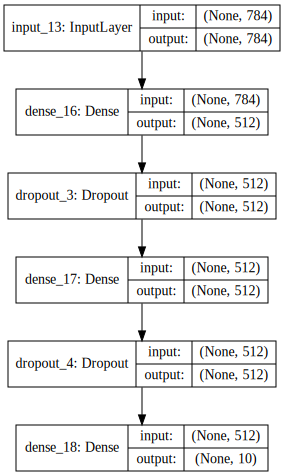

In [29]:
draw_model_graph(model)

It's actually closer to this:

(blue color represents our ```Model()```)

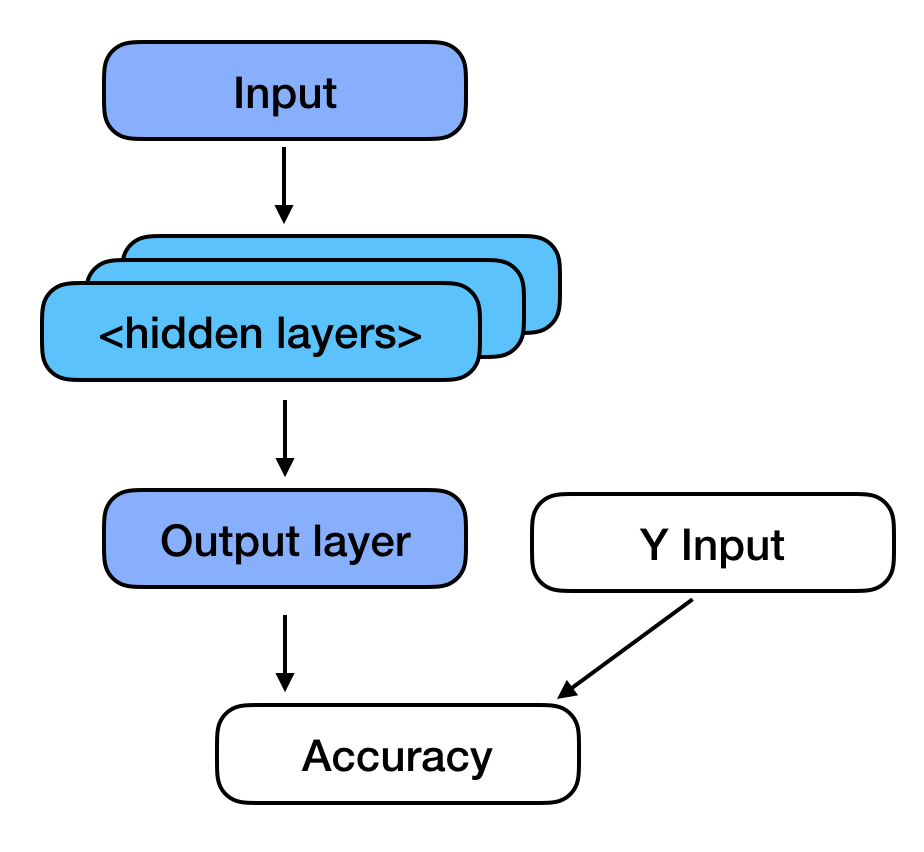

In [4]:
Image(filename='images/graph_with_acc.png', width=500)

The same graph represented as screenshot from Tensorboard (with hidden Dropout layers)

First, the "main" model:

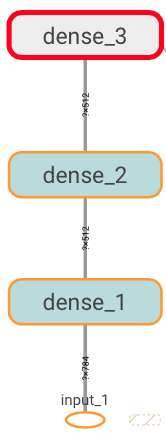

In [5]:
Image(filename='images/tensorboard_graph_1.png', height=500)

and the same model but with ```accuracy```

( Compare this graph elements with our ```calc_accuracy``` method used by ```Lambda``` layer )

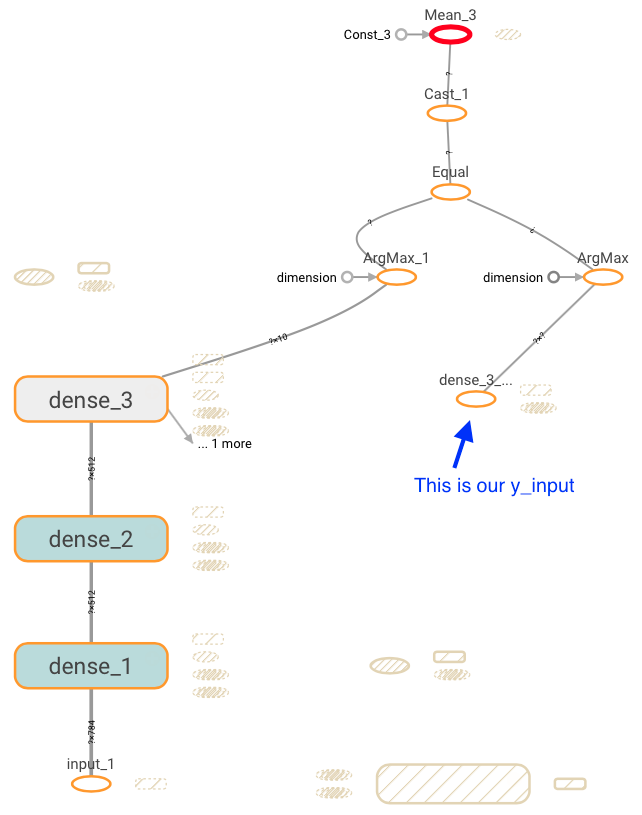

In [6]:
Image(filename='images/tensorboard_graph_2.png', height=500)

### How to execute our new ```accuracy``` operation?

Simply use ```K.function()```. 

Keras documentation says:

```def function(inputs, outputs, updates=None, **kwargs):```

    Instantiates a Keras function.

    # Arguments
        inputs: List of placeholder tensors.
        outputs: List of output tensors.
        updates: List of update ops.
        **kwargs: Passed to `tf.Session.run`.

    # Returns
        Output values as Numpy arrays.
        

If you'd check the original implementation, you would see that it's TensorFlow wrapper of ```session.run()``` with your ```input```s being used in ```feed_dict``` arguments:

    session.run([outputs], feed_dict=inputs_dictionary)
    
*Refer to [introduction to TensorFlow](https://www.tensorflow.org/get_started/get_started) if you don't understand what I'm talking about.*

----------- 

So, to calculate accuracy using ```K.function()``` on our test set, we need to do following:

In [36]:
# Note: This code will return error, read comment below to understand why.
accuracy_fn = K.function(inputs=[input, y_input], 
                         outputs=[accuracy])
accuracy_fn([x_test, y_test])

In order to make it work, we should tell Keras/TensorFlow in which phase - train or test phase - we want to execute our ```K.function()```

Why? Because some layers have to know in which phase they are, e.g. ```Dropout()``` should be skipped in test phase.

Here is our code extended with additional input (in TensorFlow called ```Placeholder```) with phase ```K.learning_phase()``` set to ```0``` which means it's a test phase.

In [37]:
accuracy_fn = K.function(inputs=[input, y_input, K.learning_phase()], 
                         outputs=[accuracy])
accuracy_fn([x_test, y_test, 0])

[0.97240001]

You can compare this output with original ```model.evaluate()``` output to see they are similar.

---------------

In other words, ```K.function()``` (similarly to TensorFlow's ```session.run()``` ) allows you to run custom operations on sub-parts of your graph. 

Below example shows how to get output from our model's second ```Dense()``` layer

In [44]:
# input_values is an single 25x25 flattened "image" with random values
input_values = np.random.rand(1, 784)

second_layer = K.function(inputs=[input], 
                          outputs=[dense1])
dense1_output = second_layer([input_values, 0])[0]

print("Our dense1 layer output shape is")
dense1_output.shape

Our dense1 layer output shape is


(1, 512)